In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from tqdm import tqdm_notebook

sns.set()
sns.color_palette("viridis")
# sharper plots
%config InlineBackend.figure_format = 'retina'

In [2]:
class GradientBoosting(BaseEstimator):
    def __init__(
        self,
        n_estimators=10,
        learning_rate=0.01,
        max_depth=3,
        random_state=17,
        loss_name="mse",
        debug=False,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.loss_name = loss_name
        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0], 1])
        self.debug = debug

        if loss_name == "log_loss":
            self.objective = self.log_loss
            self.objective_grad = self.log_loss_grad
        elif loss_name == "mse":
            self.objective = mean_squared_error
            self.objective_grad = self.mse_grad
        elif loss_name == "rmsle":
            self.objective = self.rmsle
            self.objective_grad = self.rmsle_grad
        elif loss_name == "rmspe":
            self.objective = rmspe
            self.objective_grad = self.rmspe_grad

        self.trees_ = []
        self.loss_by_iter = []

        if self.debug:
            self.residuals = []
            self.temp_pred = []

    def sigma(self, z):
        z = z.reshape([z.shape[0], 1])
        z[z > 100] = 100
        z[z < -100] = -100
        return 1.0 / (1 + np.exp(-z))

    def log_loss(self, y, p):
        return log_loss(y, p, normalize=False)

    def log_loss_grad(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        p[p < 1e-5] = 1e-5
        p[p > 1 - 1e-5] = 1 - 1e-5
        return (p - y) / p / (1 - p)

    def mse_grad(self, y, p):
        return 2 * (p - y.reshape([y.shape[0], 1])) / y.shape[0]

    def rmsle(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        return np.mean(np.log((p + 1) / (y + 1)) ** 2) ** 0.5

    def rmsle_grad(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        return (
            1.0 / (y.shape[0] * (p + 1) * self.rmsle(y, p)) * np.log((p + 1) / (y + 1))
        )

    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)

        prediction = b.copy()

        for t in range(self.n_estimators):

            resid = -self.objective_grad(y, prediction)

            # In order to get insights about the algorithm on toy examples (debug=True),
            # we will track residuals (anti gradient) at each iteration.
            if self.debug:
                self.residuals.append(resid)

            # Train a regression tree on the residuals.
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth, random_state=self.random_state
            )
            tree.fit(X, resid)

            b = tree.predict(X).reshape([X.shape[0], 1])

            # For debugging purposes, we will save the prediction at each iteration.
            if self.debug:
                self.temp_pred.append(b)

            self.trees_.append(tree)

            prediction += self.learning_rate * b

            self.loss_by_iter.append(self.objective(y, prediction))

        # Save the prediction on the train set.
        self.train_pred = prediction

        # For the case of log_loss, apply the sigma transformation to get back to probabilities,
        # that is the estimates of the positive class classification
        if self.loss_name == "log_loss":
            self.train_pred = self.sigma(self.train_pred)

        return self

    def predict_proba(self, X):

        # At first, our prediction is just the average of respones.
        pred = np.ones([X.shape[0], 1]) * np.mean(self.y)

        # Add the predictions of the trees.
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X).reshape(
                [X.shape[0], 1]
            )

        # In the case of log_loss, apply the sigmoid function to get back to probabilities.
        if self.loss_name == "log_loss":
            return self.sigma(pred)
        else:
            return pred

    def predict(self, X):

        pred_probs = self.predict_proba(X)

        # In the case of classification, to predict a binary class (label),
        # we will choose the threshold that yields the maximum accuracy.
        if self.loss_name == "log_loss":
            max_accuracy = 0
            best_thres = 0
            for thres in np.linspace(0.01, 1.01, 100):
                acc = accuracy_score(self.y, self.train_pred > thres)
                if acc > max_accuracy:
                    max_accuracy = acc
                    best_thres = thres
            return pred_probs > best_thres
        else:
            # This solution is not perfect: in the case of regression,
            # `predict` will call `predict_proba` and return the same value.
            # We do it so as not to implement the classifier and regressor as separate classes.
            # Though, we could derive both of these classes from `GradientBoosting`.
            return pred_probs

In [3]:
def get_1d_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    return np.arange(x_min, x_max, eps)


def get_2d_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps), np.arange(y_min, y_max, eps))

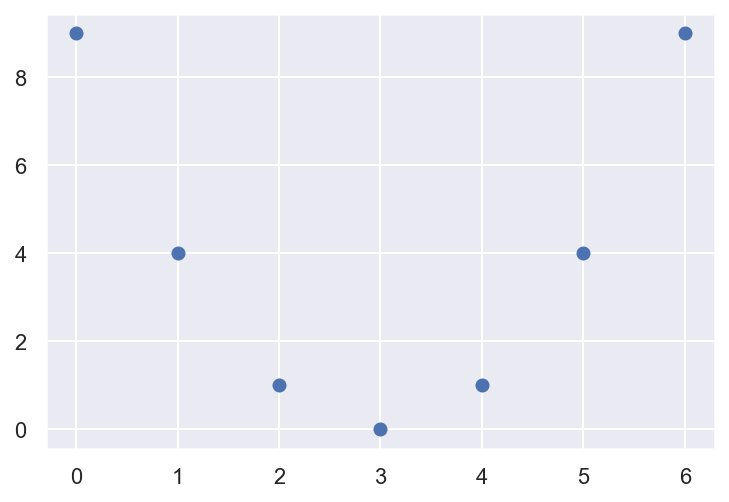

In [4]:
X_regr_toy = np.arange(7).reshape(-1, 1)

y_regr_toy = ((X_regr_toy - 3) ** 2).astype("float64")

plt.scatter(X_regr_toy, y_regr_toy);

In [5]:
boost_regr_mse = GradientBoosting(
    n_estimators=200, loss_name="mse", max_depth=3, learning_rate=0.1, debug=True
)
boost_regr_mse.fit(X_regr_toy, y_regr_toy);

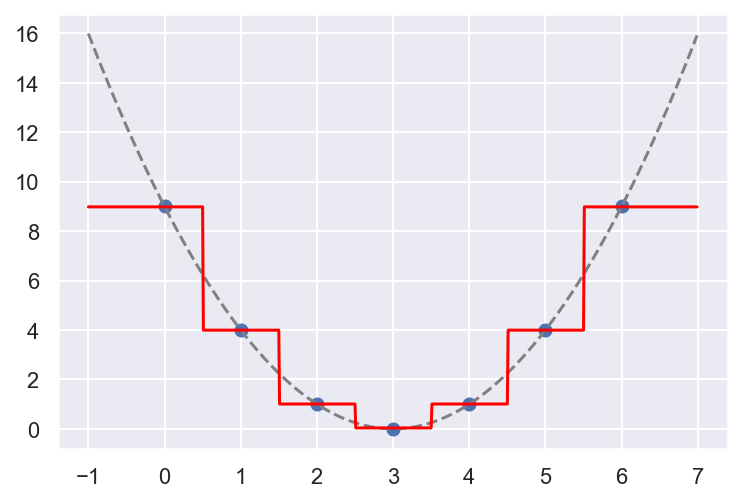

In [6]:
xx = get_1d_grid(X_regr_toy)
plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
plt.scatter(X_regr_toy, y_regr_toy)
plt.plot(xx, boost_regr_mse.predict(xx.reshape([xx.shape[0], 1])), color="red");

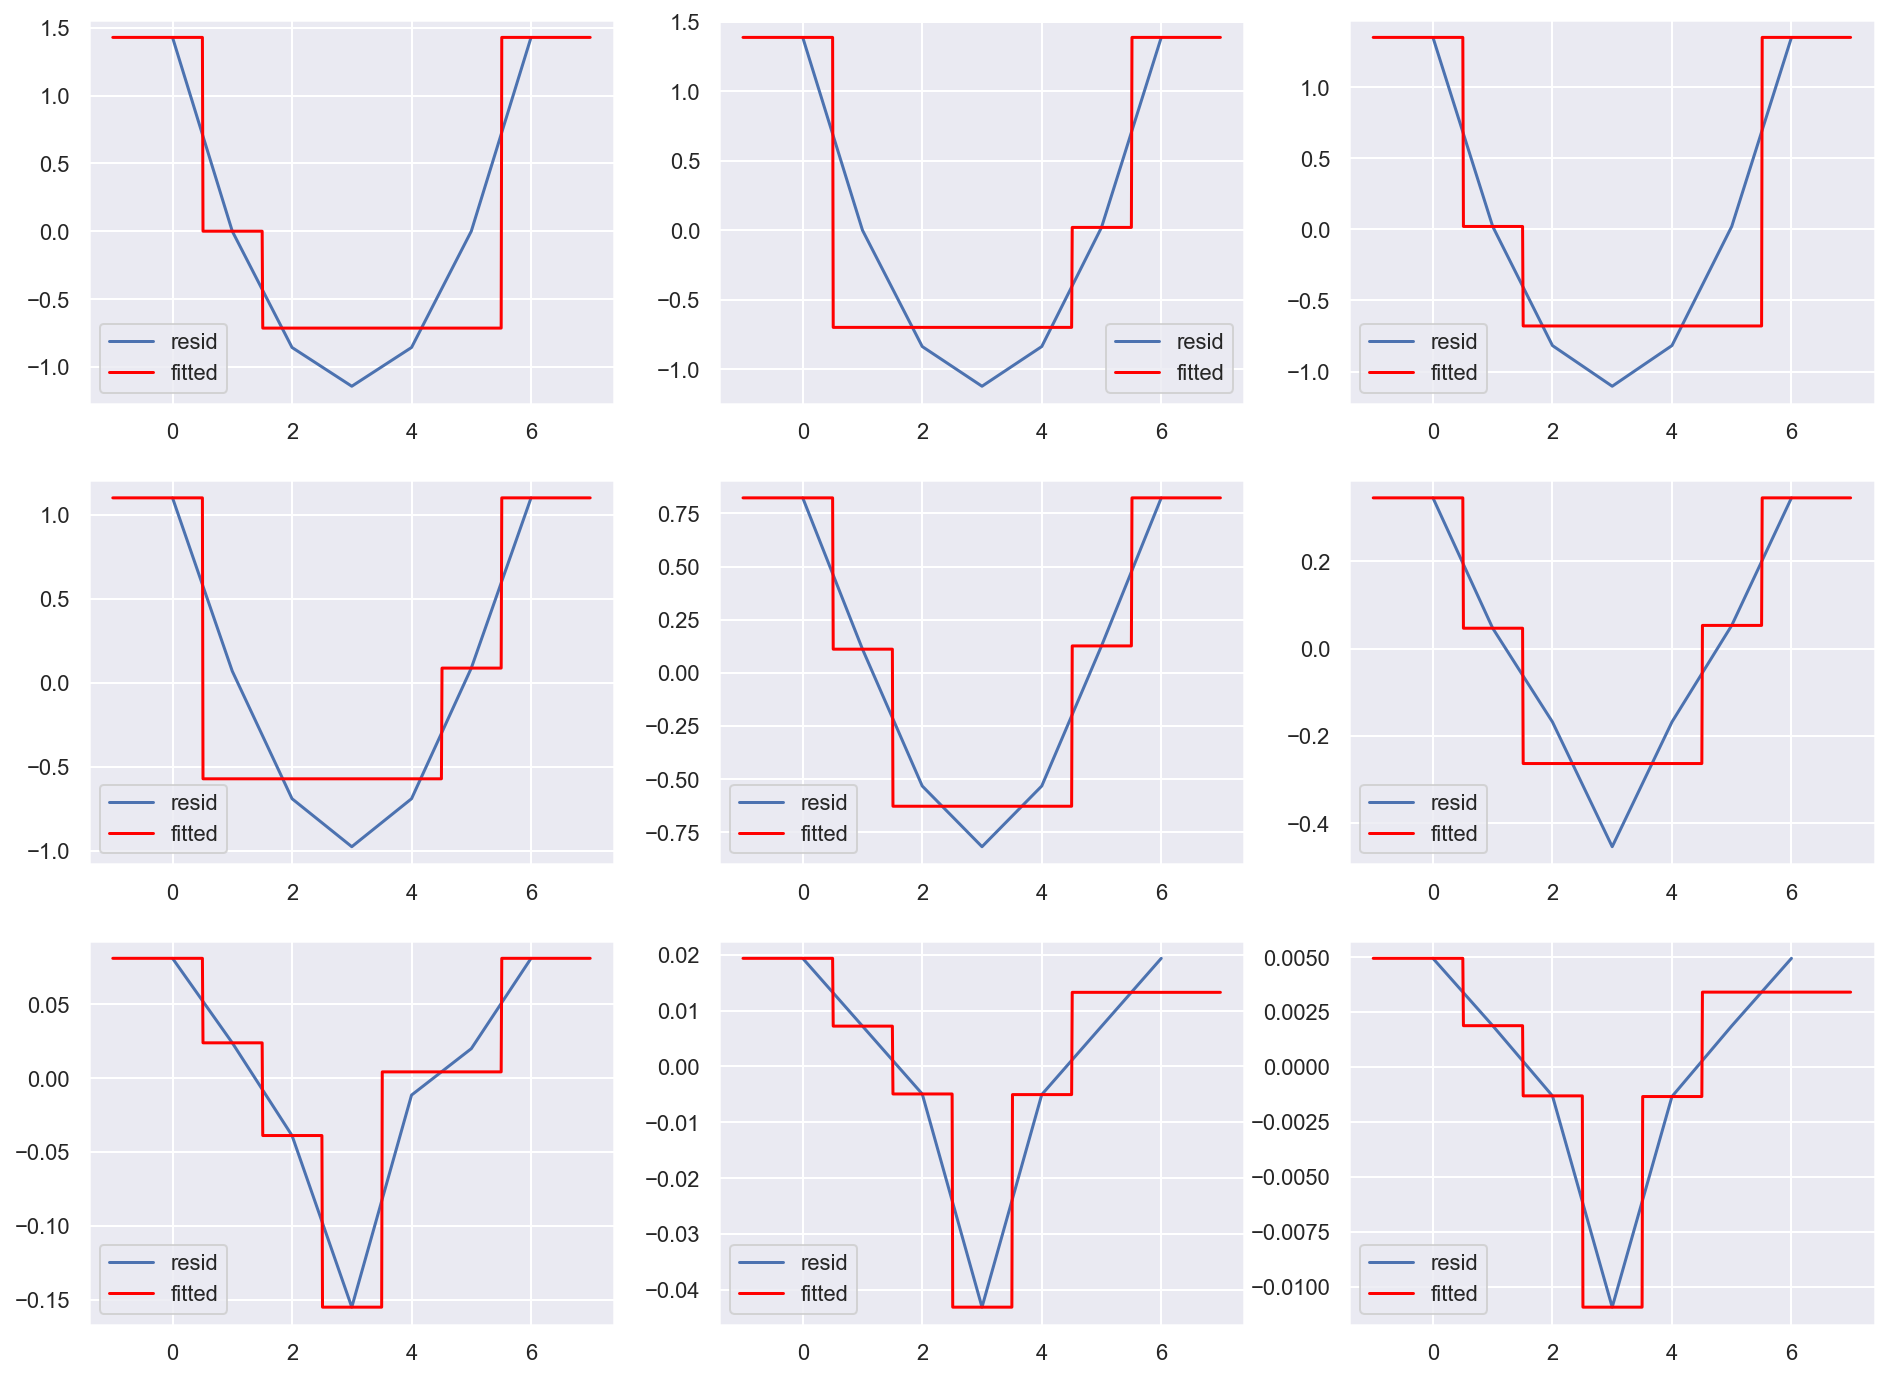

In [7]:
plt.rcParams["figure.figsize"] = (16, 12)

plt.subplots(3, 3)

for i, tree_idx in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    plt.plot(X_regr_toy, boost_regr_mse.residuals[tree_idx - 1], label="resid")
    plt.plot(
        xx,
        boost_regr_mse.trees_[tree_idx - 1].predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted",
    )
    plt.legend();

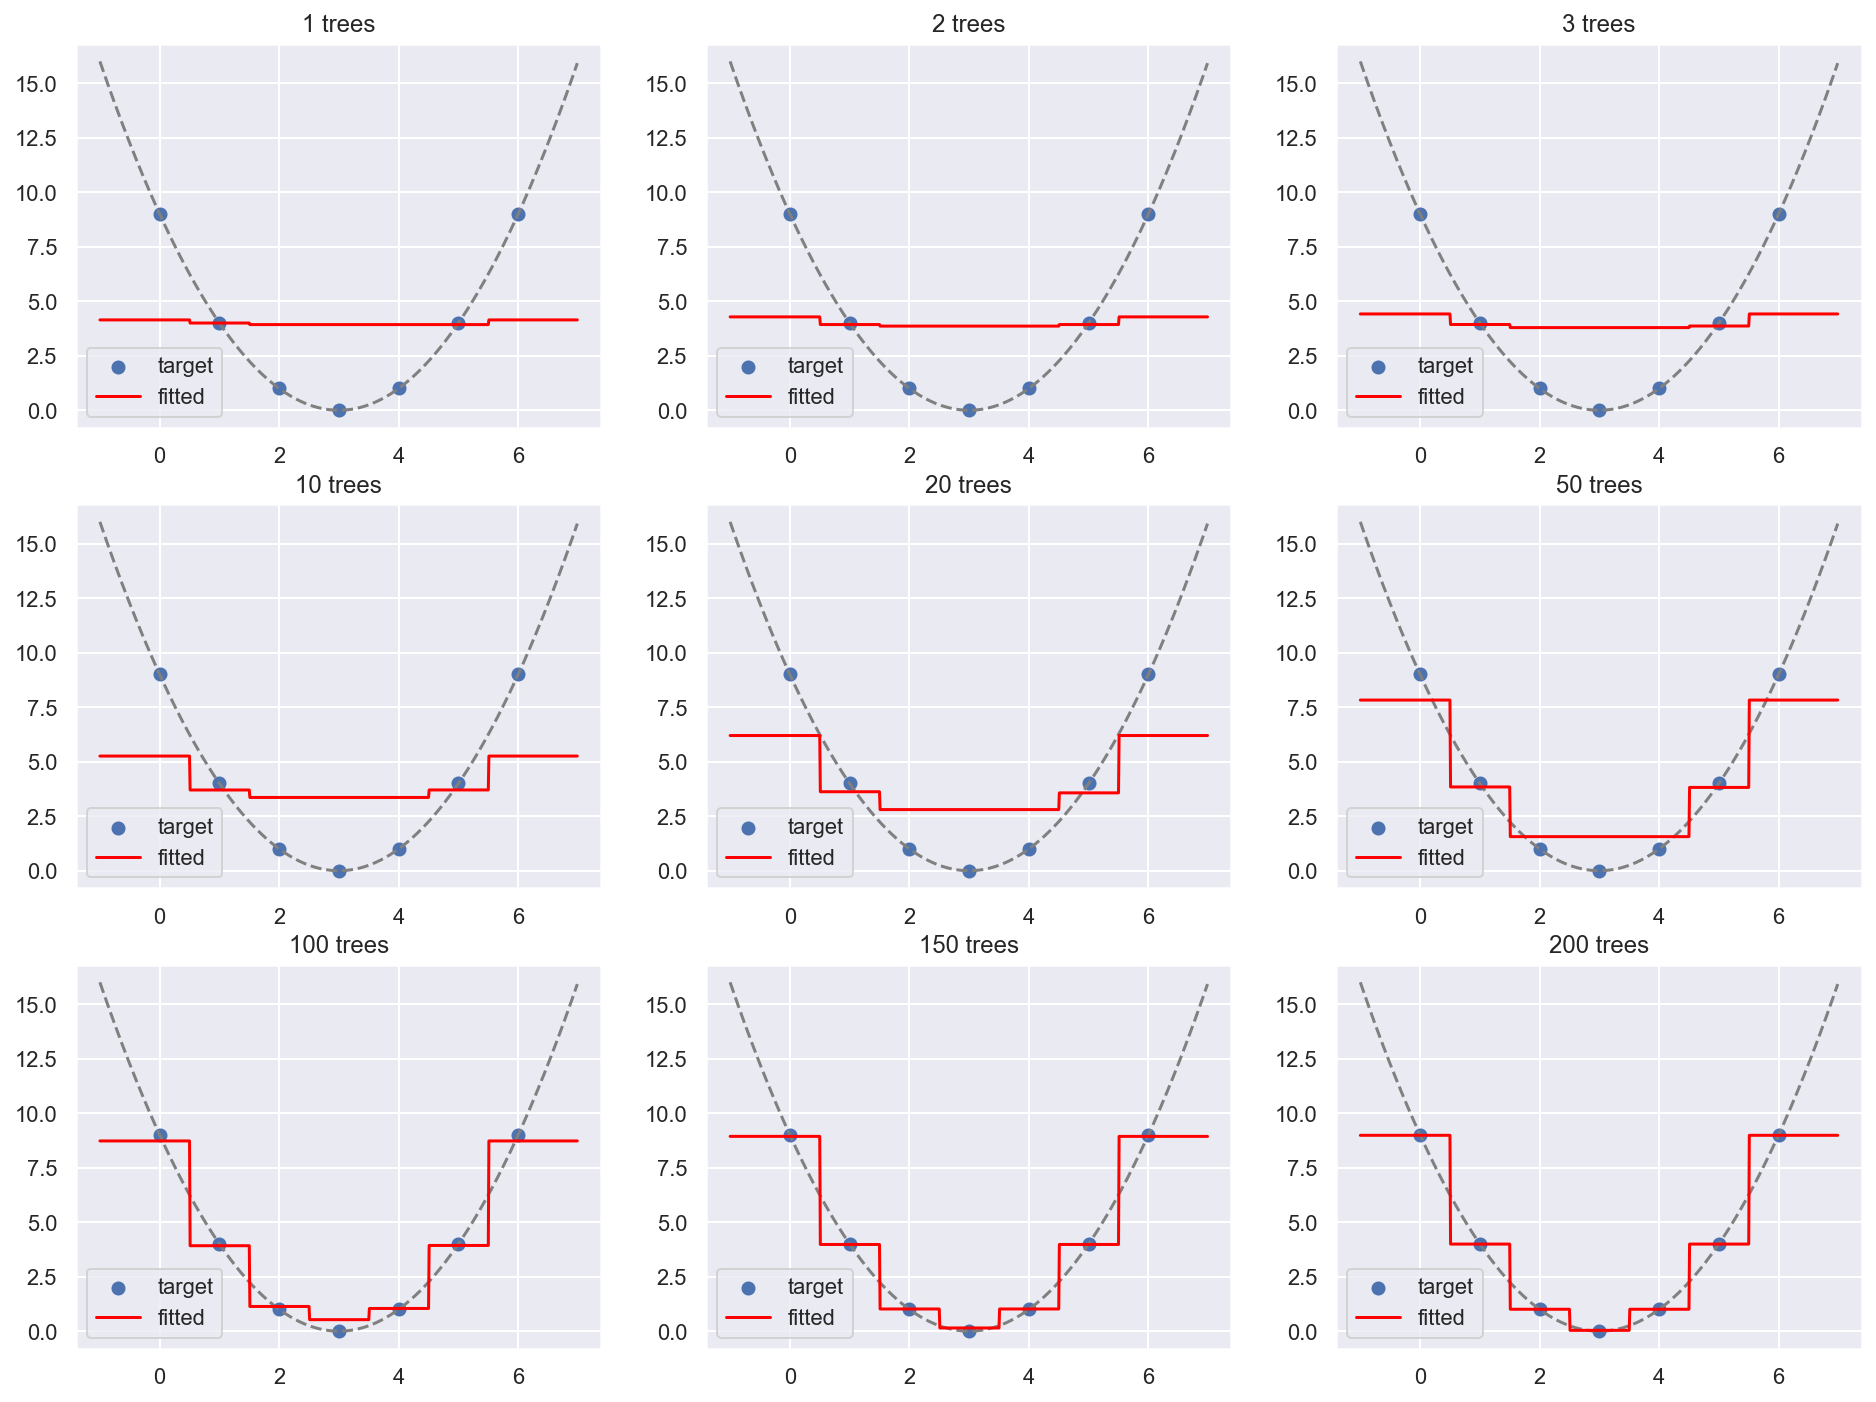

In [8]:
plt.subplots(3, 3)

for i, n_trees in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)

    boost_regr = GradientBoosting(
        n_estimators=n_trees,
        loss_name="mse",
        max_depth=3,
        learning_rate=0.1,
        debug=True,
    )
    boost_regr.fit(X_regr_toy, y_regr_toy)

    plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
    plt.scatter(X_regr_toy, y_regr_toy, label="target")
    plt.plot(
        xx,
        boost_regr.predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted",
    )
    plt.legend()
    plt.title("%s trees" % str(n_trees));

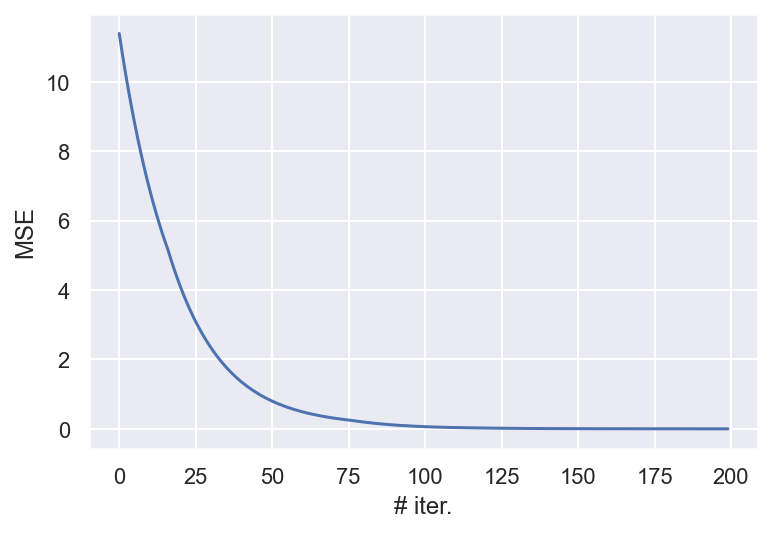

In [9]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(range(len(boost_regr_mse.loss_by_iter)), boost_regr_mse.loss_by_iter)
plt.xlabel("# iter.")
plt.ylabel("MSE");

In [10]:
boost_regr_rmsle = GradientBoosting(
    n_estimators=200, loss_name="rmsle", max_depth=3, learning_rate=0.5, debug=True
)
boost_regr_rmsle.fit(X_regr_toy, y_regr_toy);

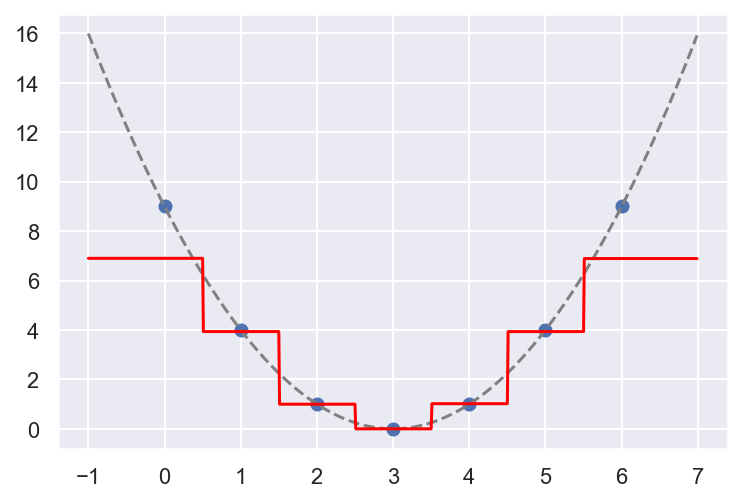

In [11]:
xx = get_1d_grid(X_regr_toy)
plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
plt.scatter(X_regr_toy, y_regr_toy)
plt.plot(xx, boost_regr_rmsle.predict(xx.reshape([xx.shape[0], 1])), color="red");

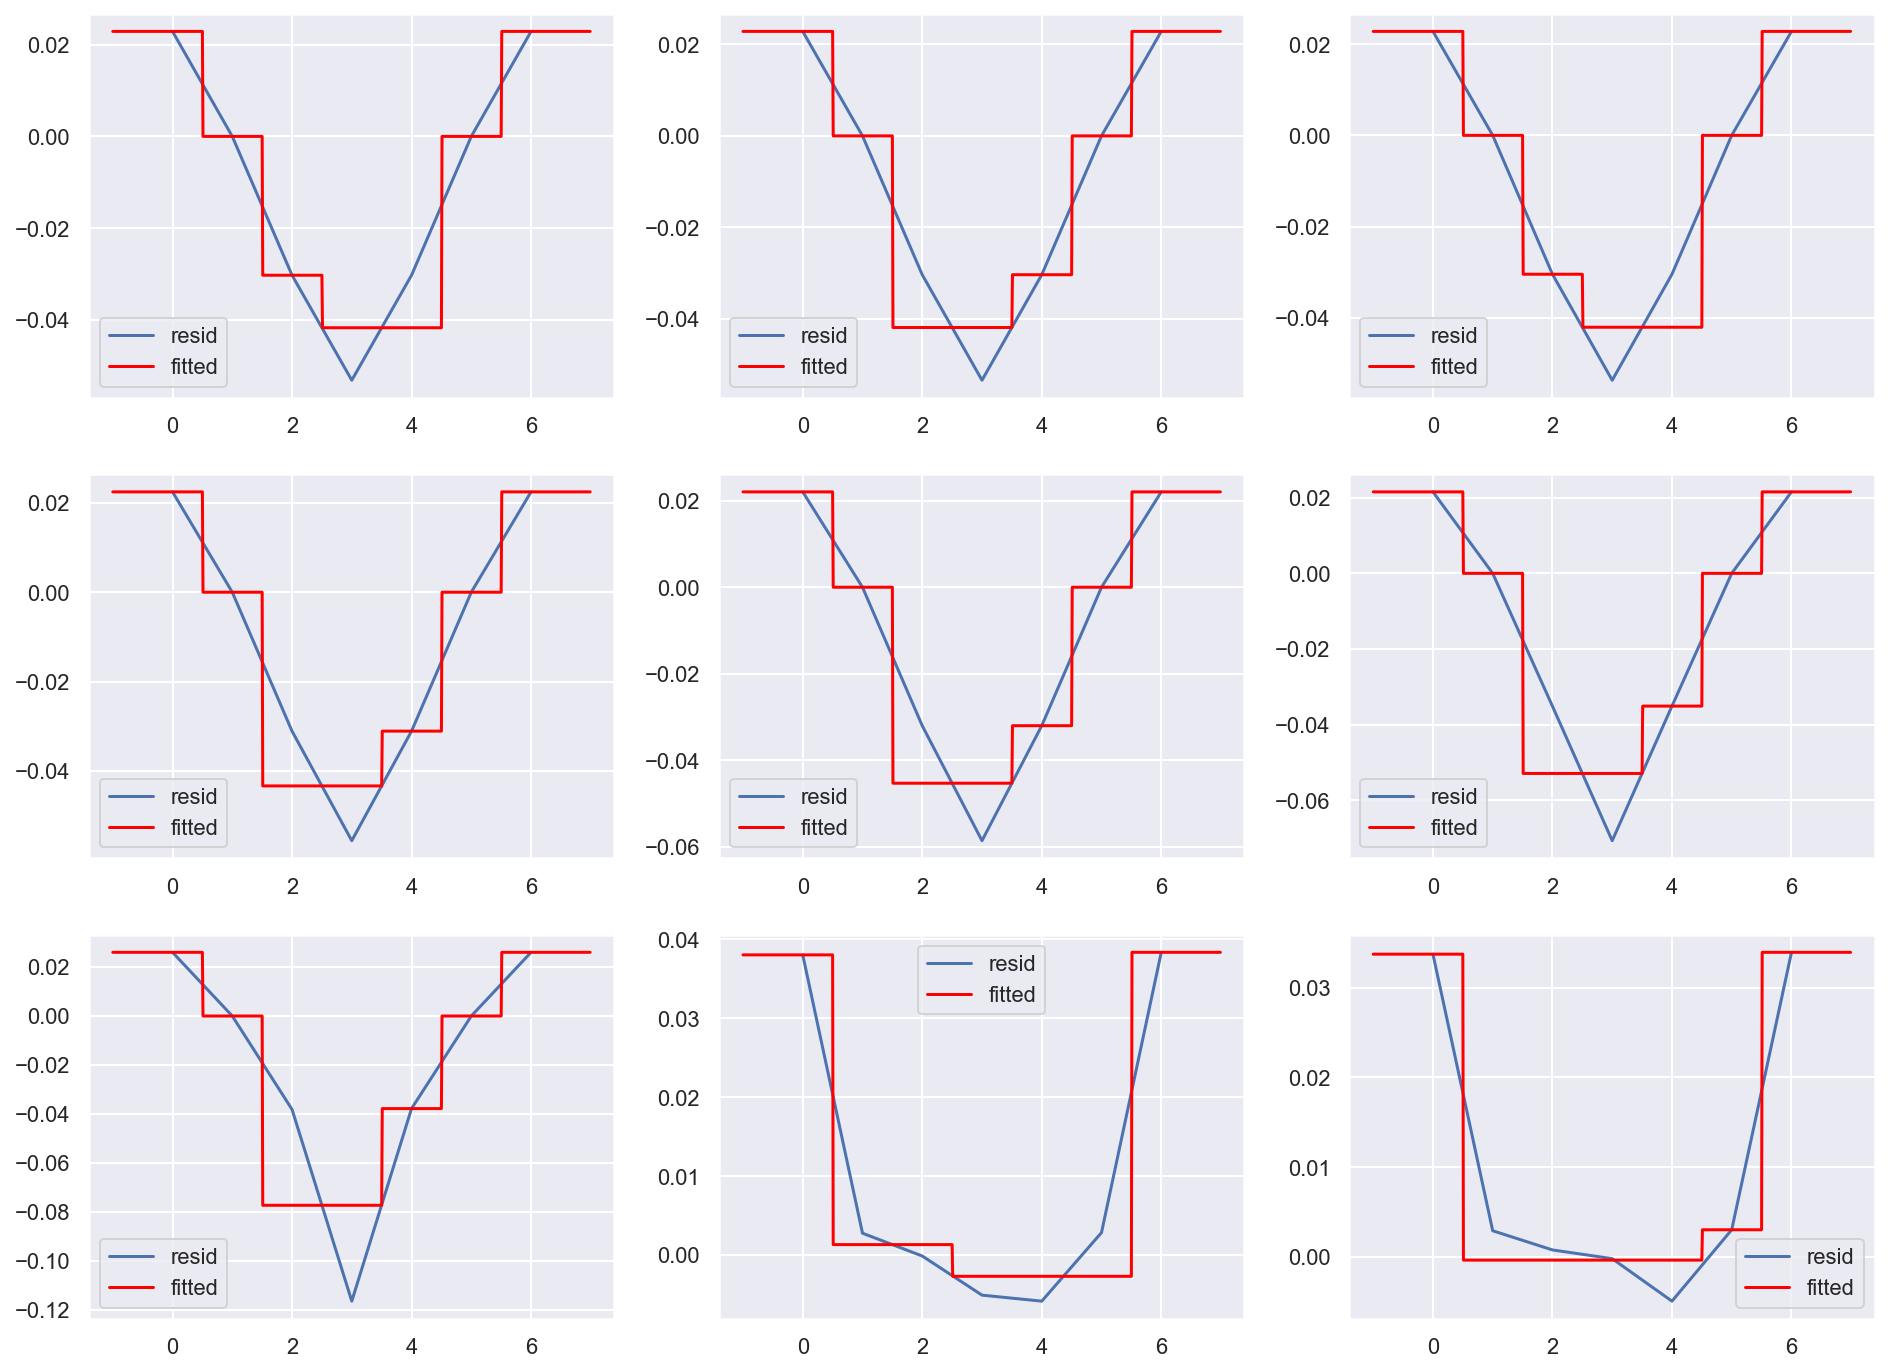

In [12]:
plt.rcParams["figure.figsize"] = (16, 12)

plt.subplots(3, 3)

for i, tree_idx in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    plt.plot(X_regr_toy, boost_regr_rmsle.residuals[tree_idx - 1], label="resid")
    plt.plot(
        xx,
        boost_regr_rmsle.trees_[tree_idx - 1].predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted",
    )
    plt.legend();

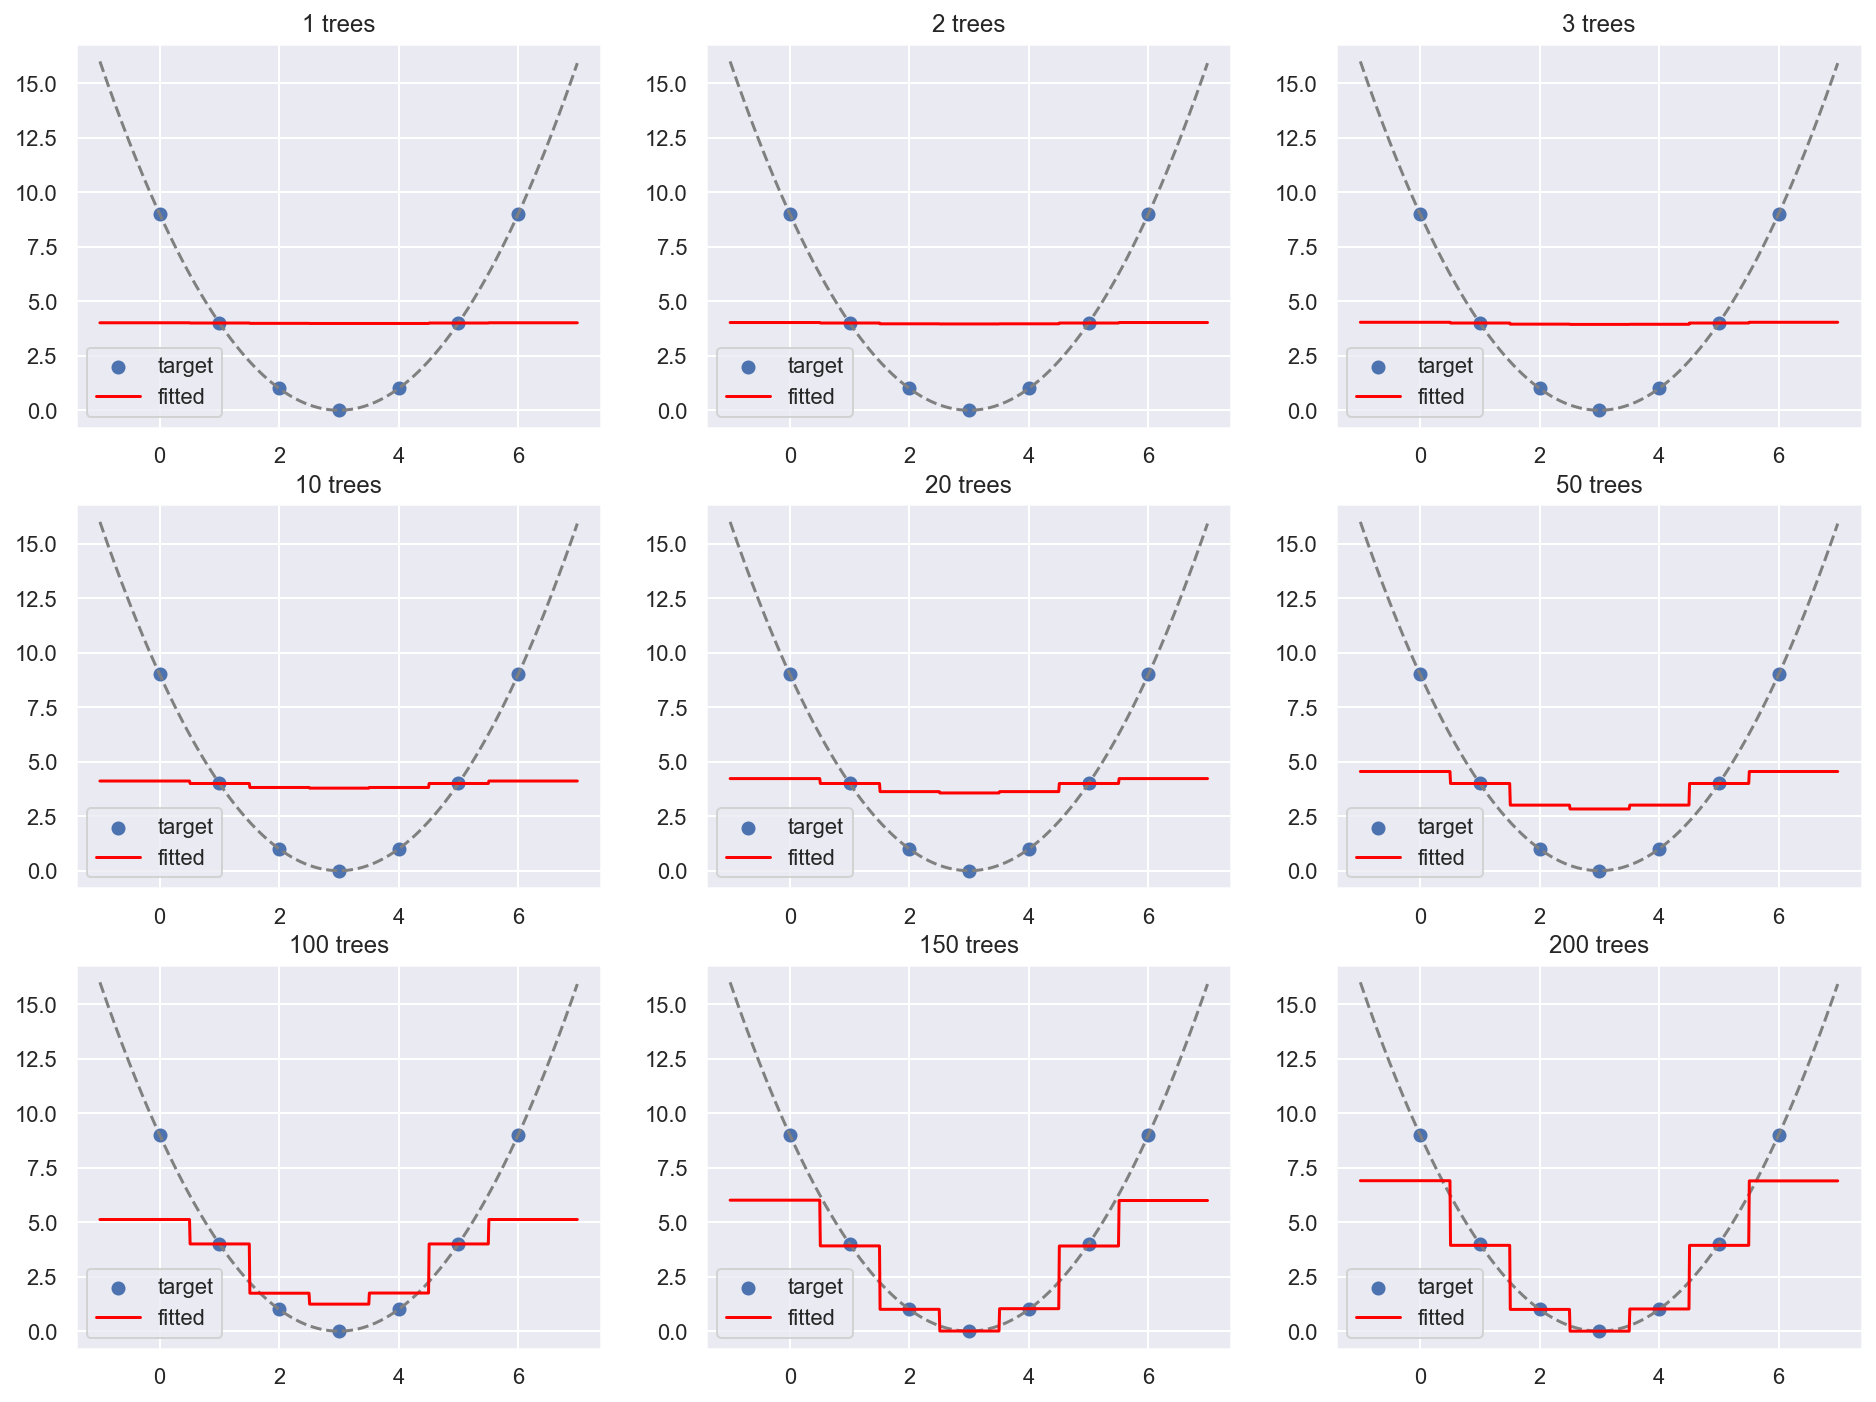

In [13]:
plt.subplots(3, 3)

for i, n_trees in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)

    boost_regr = GradientBoosting(
        n_estimators=n_trees, loss_name="rmsle", max_depth=3, learning_rate=0.5
    )
    boost_regr.fit(X_regr_toy, y_regr_toy)

    plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
    plt.scatter(X_regr_toy, y_regr_toy, label="target")
    plt.plot(
        xx,
        boost_regr.predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted",
    )
    plt.legend()
    plt.title("%s trees" % str(n_trees));

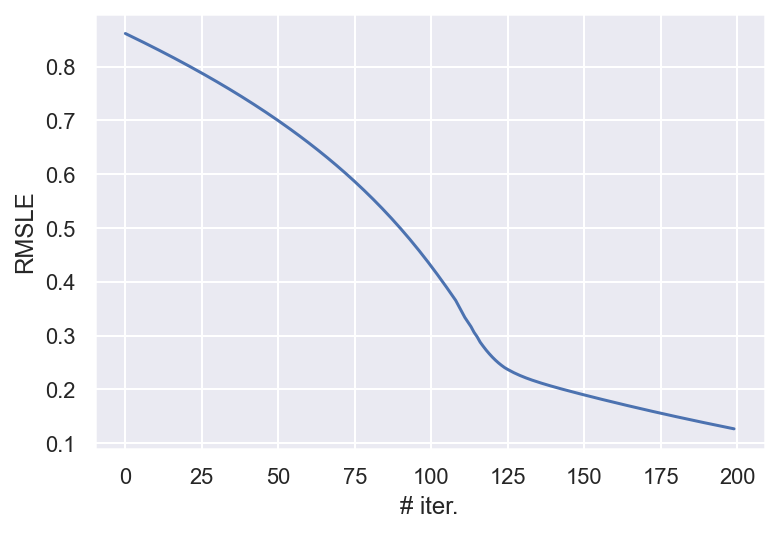

In [14]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(range(len(boost_regr_rmsle.loss_by_iter)), boost_regr_rmsle.loss_by_iter)
plt.xlabel("# iter.")
plt.ylabel("RMSLE");

In [15]:
X_clf_toy = np.c_[np.arange(7), (np.arange(7) - 3) ** 2]
y_clf_toy = np.array([0, 1, 0, 1, 0, 1, 0])

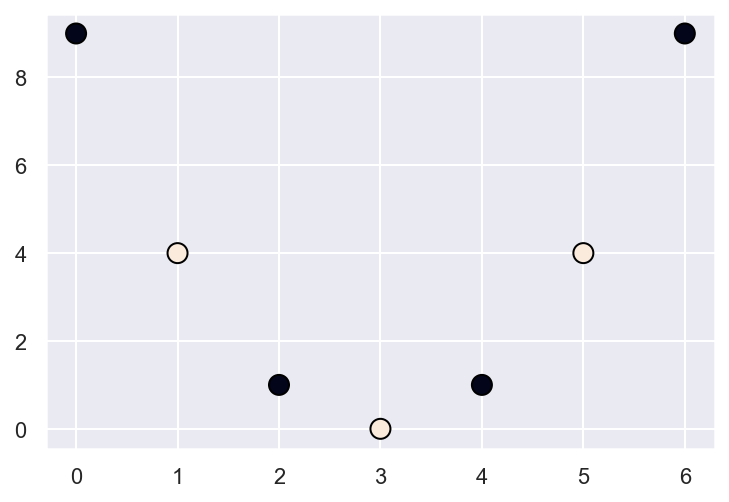

In [16]:
plt.scatter(
    X_clf_toy[:, 0],
    X_clf_toy[:, 1],
    c=y_clf_toy,
    s=100,
    edgecolors="black",
    linewidth=1,
);

In [17]:
boost_clf = GradientBoosting(
    n_estimators=10, loss_name="log_loss", max_depth=3, learning_rate=0.05
)
boost_clf.fit(X_clf_toy, y_clf_toy)

GradientBoosting(learning_rate=0.05, loss_name='log_loss')

In [18]:
clf_pred_probs = boost_clf.predict_proba(X_clf_toy)

/var/folders/xs/x4nxtnxd4qq06sg5z0x951q1q7mkqq/T/ipykernel_19975/3285327446.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, predicted, cmap="viridis", alpha=0.2, shading="auto")


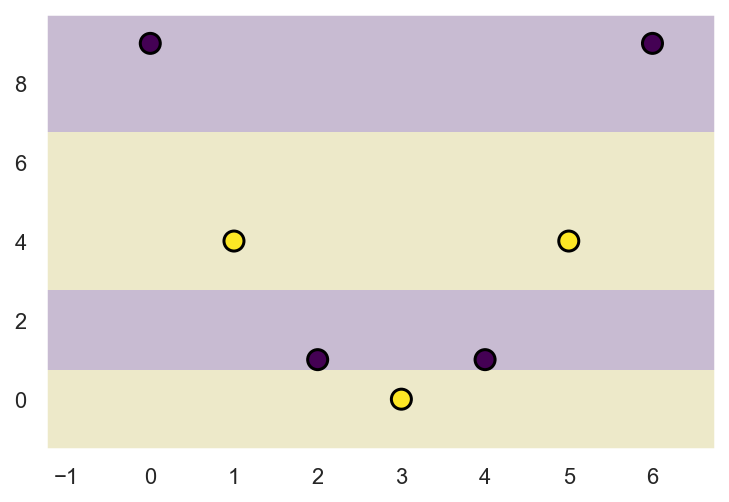

In [19]:
xx, yy = get_2d_grid(X_clf_toy, eps=0.5)
predicted = boost_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="viridis", alpha=0.2, shading="auto")
plt.scatter(
    X_clf_toy[:, 0],
    X_clf_toy[:, 1],
    c=y_clf_toy,
    s=100,
    cmap="viridis",
    edgecolors="black",
    linewidth=1.5,
);

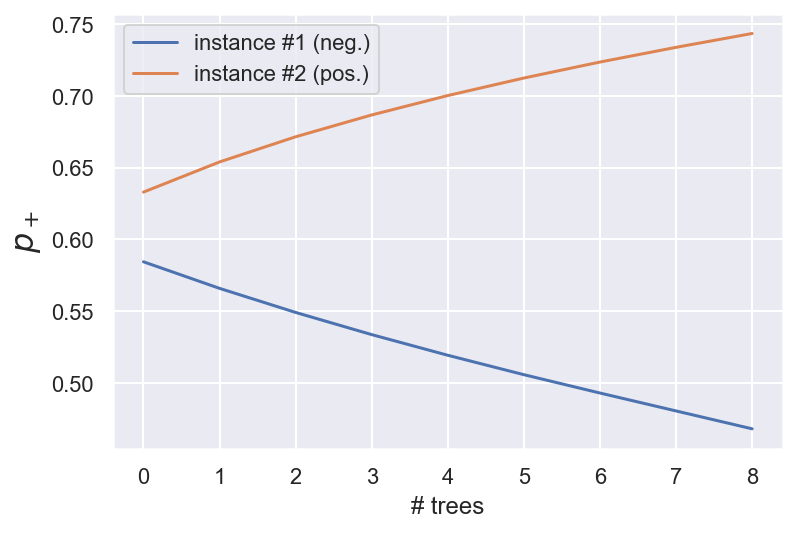

In [20]:
plt.rcParams["figure.figsize"] = (6, 4)

pred_probs1_by_tree, pred_probs2_by_tree = [], []

for i in range(9):
    boost_clf_ = GradientBoosting(
        n_estimators=i + 1, loss_name="log_loss", max_depth=3, learning_rate=0.05
    ).fit(X_clf_toy, y_clf_toy)
    pred_probs1_by_tree.append(boost_clf_.predict_proba(X_clf_toy)[0])
    pred_probs2_by_tree.append(boost_clf_.predict_proba(X_clf_toy)[1])
plt.plot(pred_probs1_by_tree, label="instance #1 (neg.)")
plt.plot(pred_probs2_by_tree, label="instance #2 (pos.)")
plt.xlabel("# trees")
plt.ylabel(r"$p_+$", fontsize=16)
plt.legend();

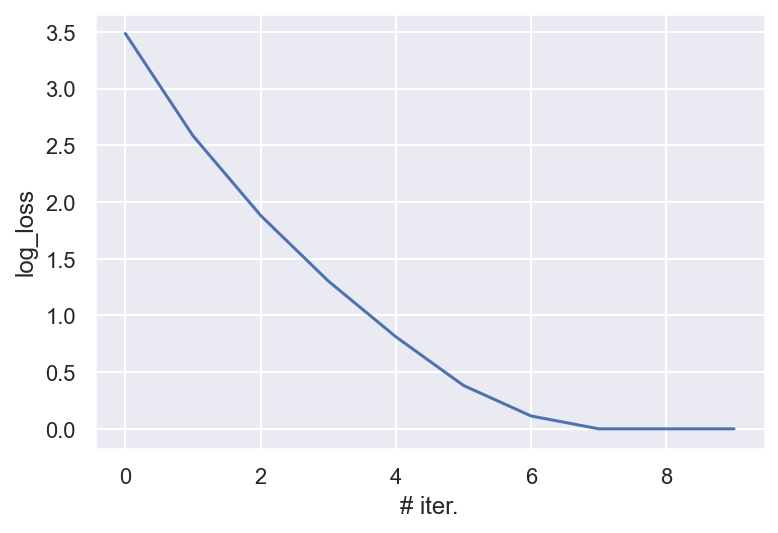

In [21]:
plt.plot(range(len(boost_clf.loss_by_iter)), boost_clf.loss_by_iter)
plt.xlabel("# iter.")
plt.ylabel("log_loss");

In [22]:
clf_pred_probs

array([[0.45554883],
       [0.75303888],
       [0.45554883],
       [0.75303888],
       [0.45554883],
       [0.75303888],
       [0.45554883]])

In [23]:
boston = load_boston()
X, y = boston.data, boston.target

/Users/kashnitskiyy/opt/anaconda3/envs/mlcourse/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [25]:
regr = GradientBoosting(
    n_estimators=300, loss_name="mse", max_depth=10, learning_rate=3
)
regr.fit(X_train, y_train)

GradientBoosting(learning_rate=3, max_depth=10, n_estimators=300)

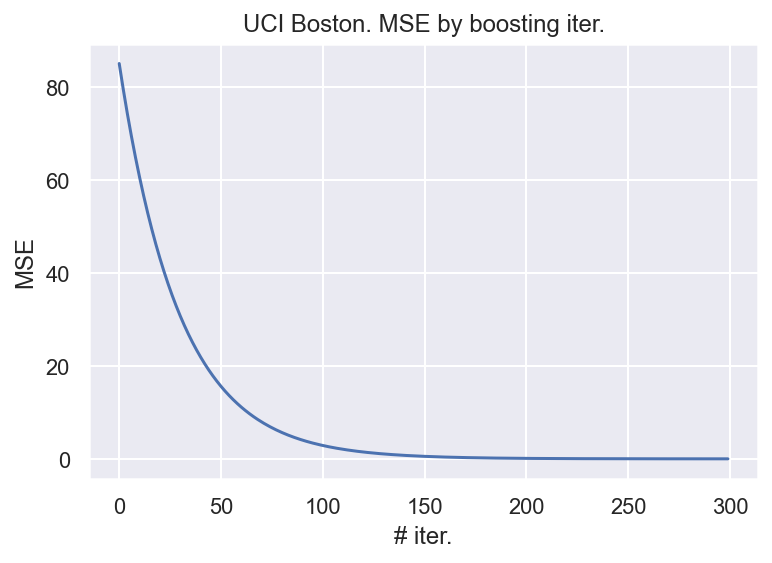

In [26]:
plt.plot(range(len(regr.loss_by_iter)), regr.loss_by_iter)
plt.xlabel("# iter.")
plt.ylabel("MSE")
plt.title("UCI Boston. MSE by boosting iter.");

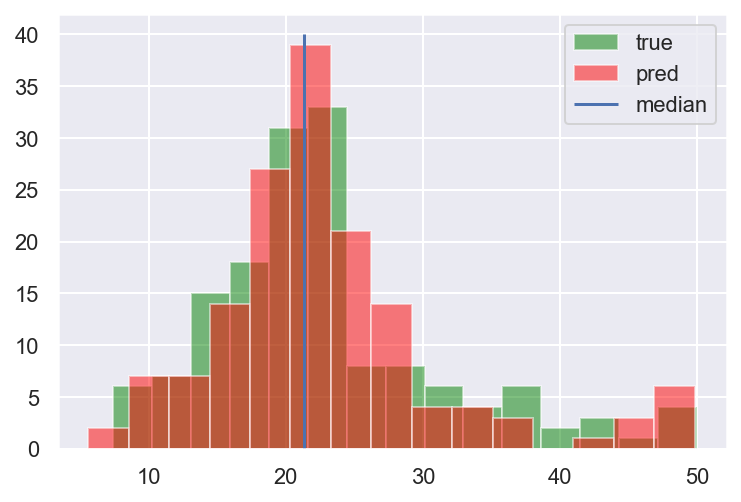

In [27]:
plt.hist(y_test, alpha=0.5, color="green", label="true", bins=15)
plt.hist(regr.predict(X_test), alpha=0.5, color="red", label="pred", bins=15)
plt.vlines(x=np.median(y_test), ymin=0, ymax=40, label="median")
plt.legend();

In [28]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [30]:
clf = GradientBoosting(
    n_estimators=200, loss_name="log_loss", max_depth=3, learning_rate=0.01
)
clf.fit(X_train, y_train)

GradientBoosting(loss_name='log_loss', n_estimators=200)

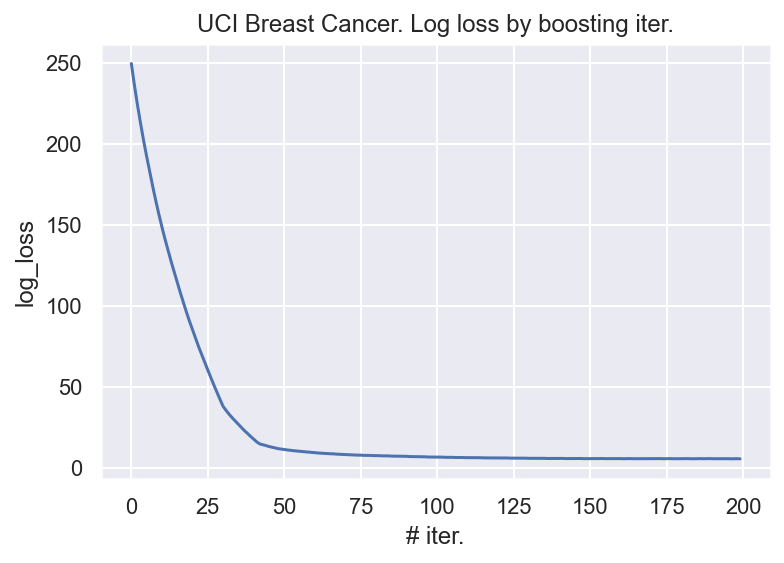

In [31]:
plt.plot(range(len(clf.loss_by_iter)), clf.loss_by_iter)
plt.xlabel("# iter.")
plt.ylabel("log_loss")
plt.title("UCI Breast Cancer. Log loss by boosting iter.");

In [32]:
pred_probs = clf.predict_proba(X_train)

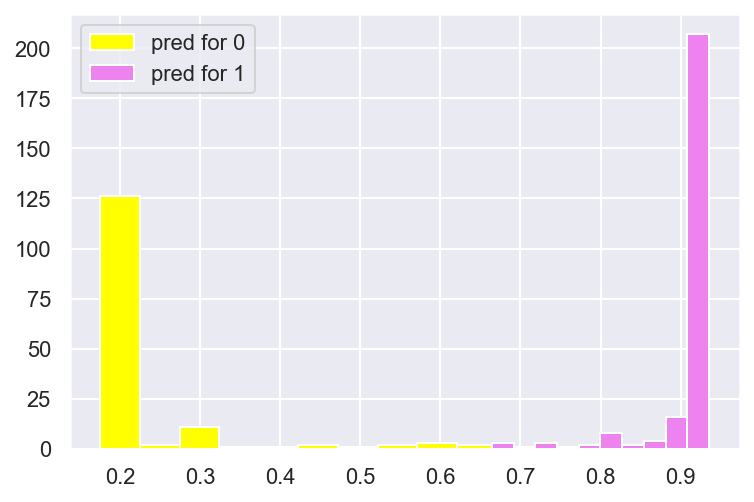

In [33]:
plt.hist(pred_probs[y_train == 0], color="yellow", label="pred for 0")
plt.hist(pred_probs[y_train == 1], color="violet", label="pred for 1")
plt.legend();

In [34]:
roc_auc_score(y_test, clf.predict_proba(X_test)), accuracy_score(
    y_test, clf.predict(X_test)
)

(0.9885245901639345, 0.9707602339181286)